In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from glob import glob
import os

! pip install -q kaggle

In [2]:
from google.colab import files

# upload kaggle.json

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adrianjuansyahhasan","key":"bbd3e968c849e0b533768b4809547f54"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d techsash/waste-classification-data

 99% 425M/427M [00:39<00:00, 18.4MB/s]
100% 427M/427M [00:39<00:00, 11.4MB/s]


In [5]:
import zipfile,os
local_zip = '/content/waste-classification-data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()
 
root_dir = ('/content/DATASET/TRAIN')


In [6]:
# os.listdir('/tmp/DATASET/TRAIN')
# os.listdir('/tmp/DATASET/TEST')
os.listdir(root_dir)

['O', 'R']

In [7]:
import pathlib
def process(data):
  path = pathlib.Path(data)
  filepaths=list(path.glob(r"*/*.jpg"))
  labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))
  df1 = pd.Series(filepaths, name='filepaths').astype(str)
  df2 = pd.Series(labels, name='labels')
  df=pd.concat([df1, df2],axis=1)
  return df

In [8]:
df_train= process(root_dir)

In [9]:
df_train

,filepaths,labels
0,/content/DATASET/TRAIN/O/O_8675.jpg,O
1,/content/DATASET/TRAIN/O/O_8048.jpg,O
2,/content/DATASET/TRAIN/O/O_11959.jpg,O
3,/content/DATASET/TRAIN/O/O_3093.jpg,O
4,/content/DATASET/TRAIN/O/O_9947.jpg,O
...,...,...
22559,/content/DATASET/TRAIN/R/R_5184.jpg,R
22560,/content/DATASET/TRAIN/R/R_1644.jpg,R
22561,/content/DATASET/TRAIN/R/R_6390.jpg,R
22562,/content/DATASET/TRAIN/R/R_8818.jpg,R


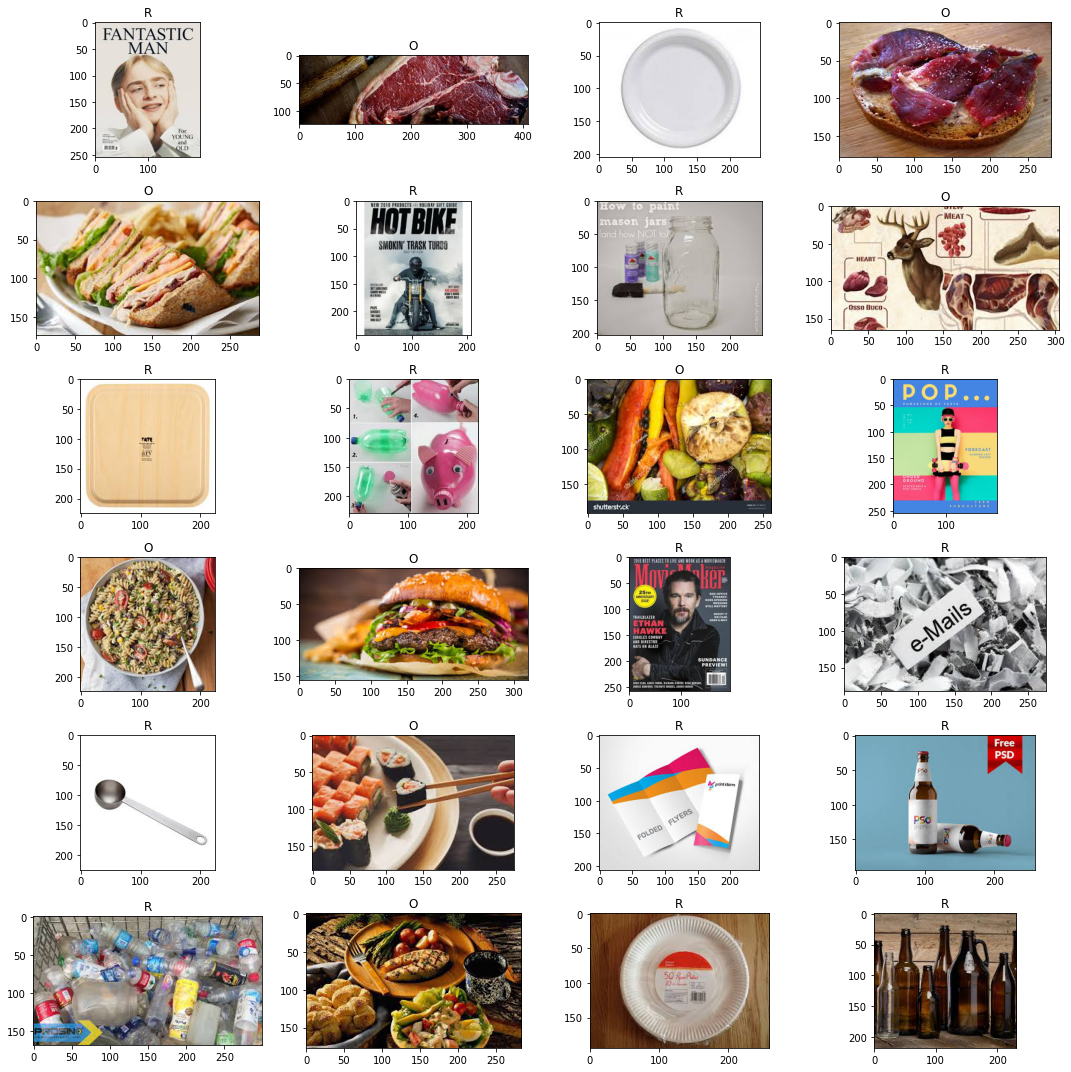

In [10]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
fig, axes=plt.subplots(nrows=6,ncols=4,figsize=(15,15))

for i,ax in enumerate(axes.flat):
  x=plt.imread(df_train['filepaths'][i])
  ax.imshow(x)
  ax.set_title(df_train['labels'][i])
plt.tight_layout()
plt.show()

In [11]:
x = (df_train.labels == 'O').sum()
y = (df_train.labels == 'R').sum()

print("Label Oganic pada Dataset ada", x)
print("Label Non-Organic pada Dataset ada", y)


Label Oganic pada Dataset ada 12565
Label Non-Organic pada Dataset ada 9999


In [12]:
classes=['Organic','Non-Organic']

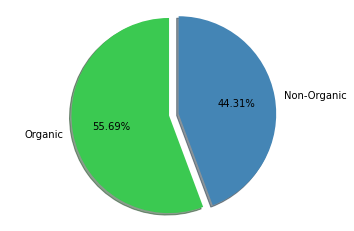

<Figure size 720x576 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = classes
sizes = [x, y]
colors = ['#3BC951','#4485B5']
explode = (0.05, 0.05)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
plt.figure(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%0.2f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

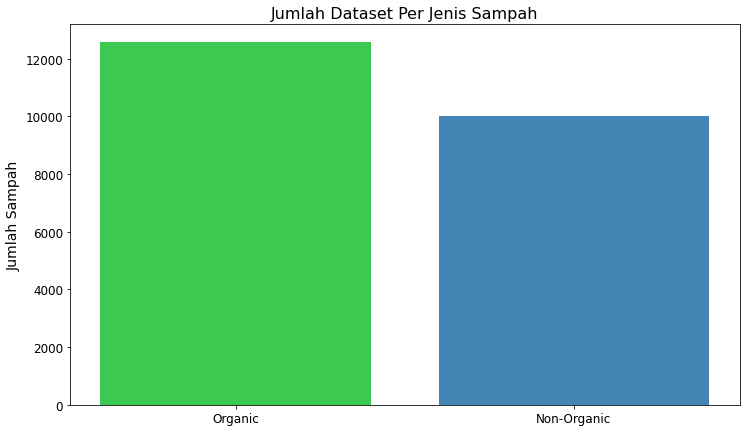

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

prodi = classes
jumlah_mhs = [x, y]
colors = ['#3BC951','#4485B5']

plt.figure(figsize=(12,7))
plt.bar(prodi, jumlah_mhs, color=colors)

plt.title('Jumlah Dataset Per Jenis Sampah', size=16)
plt.ylabel('Jumlah Sampah', size=14)
plt.xticks(size=12)
plt.yticks(size=12)

plt.show()

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   validation_split=0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest')

train_set = train_datagen.flow_from_dataframe(dataframe= df_train,
                                              x_col='filepaths',
                                              y_col='labels',
                                              target_size = (224, 224),
                                              batch_size = 32,
                                              seed=42,
                                              subset='training',
                                              shuffle=True,
                                              class_mode = 'categorical')

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_set = test_datagen.flow_from_dataframe(dataframe= df_train,
                                            x_col='filepaths',
                                            y_col='labels',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            color_mode='rgb',
                                            seed=42,
                                            subset='validation',
                                            class_mode = 'categorical')

Found 18052 validated image filenames belonging to 2 classes.
Found 4512 validated image filenames belonging to 2 classes.


In [16]:
# Feature Extraction Layer
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten feature map
model.add(layers.Flatten())

# Fully Connected Layer
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

In [17]:
callback_cp = tf.keras.callbacks.ModelCheckpoint(
    filepath="/tmp/best-weights/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5", #hdf5 = h5 (versi singkat)
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode="max"
)
callback_es = tf.keras.callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=20)

In [18]:
optimizers = tf.keras.optimizers.Adam(learning_rate=0.0001)


model.compile(optimizer= optimizers ,loss = ('categorical_crossentropy'), metrics=['accuracy'])

history = model.fit(train_set, 
                    epochs=20, 
                    validation_data= test_set, 
                    verbose=2,
                    callbacks=[callback_es, callback_cp],
                    validation_steps=5)

Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.80625, saving model to /tmp/best-weights/weights-improvement-01-0.81.hdf5
565/565 - 204s - loss: 0.4557 - accuracy: 0.7961 - val_loss: 0.5227 - val_accuracy: 0.8062 - 204s/epoch - 361ms/step
Epoch 2/20

Epoch 2: val_accuracy did not improve from 0.80625
565/565 - 189s - loss: 0.4025 - accuracy: 0.8289 - val_loss: 0.5151 - val_accuracy: 0.7937 - 189s/epoch - 335ms/step
Epoch 3/20

Epoch 3: val_accuracy improved from 0.80625 to 0.86875, saving model to /tmp/best-weights/weights-improvement-03-0.87.hdf5
565/565 - 191s - loss: 0.3719 - accuracy: 0.8444 - val_loss: 0.3374 - val_accuracy: 0.8687 - 191s/epoch - 339ms/step
Epoch 4/20

Epoch 4: val_accuracy improved from 0.86875 to 0.87500, saving model to /tmp/best-weights/weights-improvement-04-0.88.hdf5
565/565 - 188s - loss: 0.3562 - accuracy: 0.8541 - val_loss: 0.2768 - val_accuracy: 0.8750 - 188s/epoch - 333ms/step
Epoch 5/20

Epoch 5: val_accuracy did not improve from 0.87500
565/

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

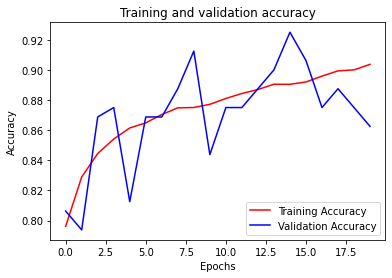

<Figure size 432x288 with 0 Axes>

In [20]:
plt.plot(epochs, acc, 'r', label ='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

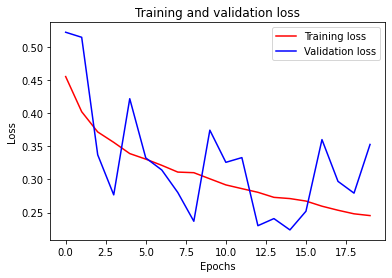

<Figure size 432x288 with 0 Axes>

In [21]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

1/1 [==============================] - 0s 161ms/step


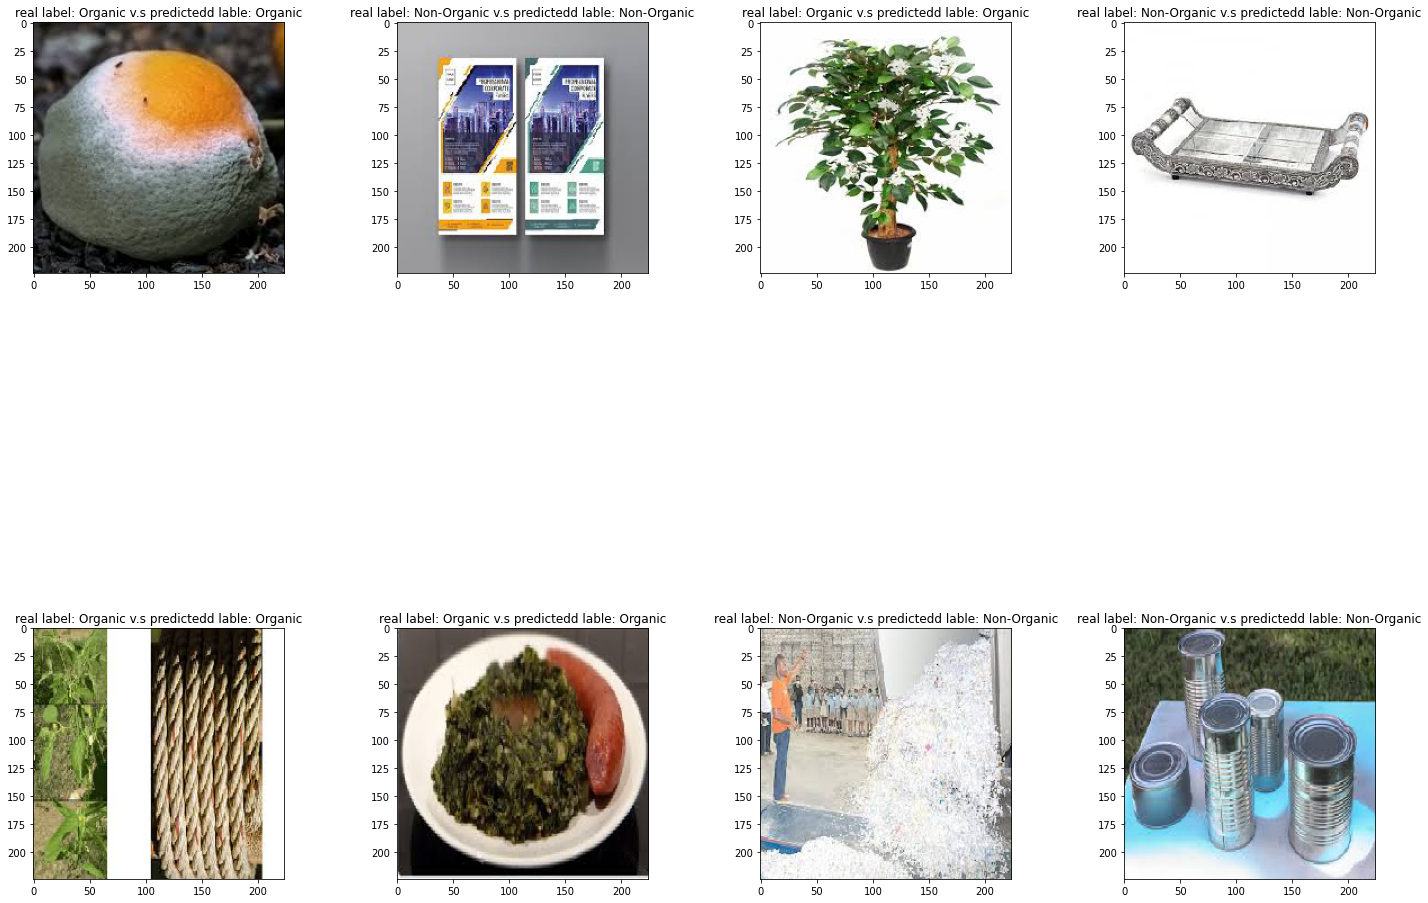

In [22]:
images, labels = test_set.next()
preds = model.predict(images)
fig,axes=plt.subplots(nrows=2,ncols=4,figsize=(20,20))
dic={i:ax for i,ax in enumerate(axes.flat)}
for i in range(0,8):
    label = np.argmax(labels[i])
    pred = np.argmax(preds[i])
    image = images[i]
    dic[i].set_title("real label: " + str(classes[label]) + " v.s " + "predictedd lable: " + str(classes[pred]))
    dic[i].imshow(image)
plt.tight_layout()    
plt.show() 

In [ ]:
# import numpy as np
# from google.colab import files
# from tensorflow.keras.preprocessing import image
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# %matplotlib inline
 
 
# uploaded = files.upload()

# for fn in uploaded.keys():
 
#   # predicting images
#   path = fn
  
#   img = image.load_img(path, target_size=(224,224))
 
#   imgplot = plt.imshow(img)
#   x = image.img_to_array(img)
#   x = np.expand_dims(x, axis=0)
#   images = np.vstack([x])
 
#   classes = model.predict(images, batch_size=10)  
#   cc = np.argmax(classes)
#   print(fn)
#   if cc == 1:
#    print('Non-Organic')
#   else:
#    print('Organic')

1/1 [==============================] - 0s 49ms/step


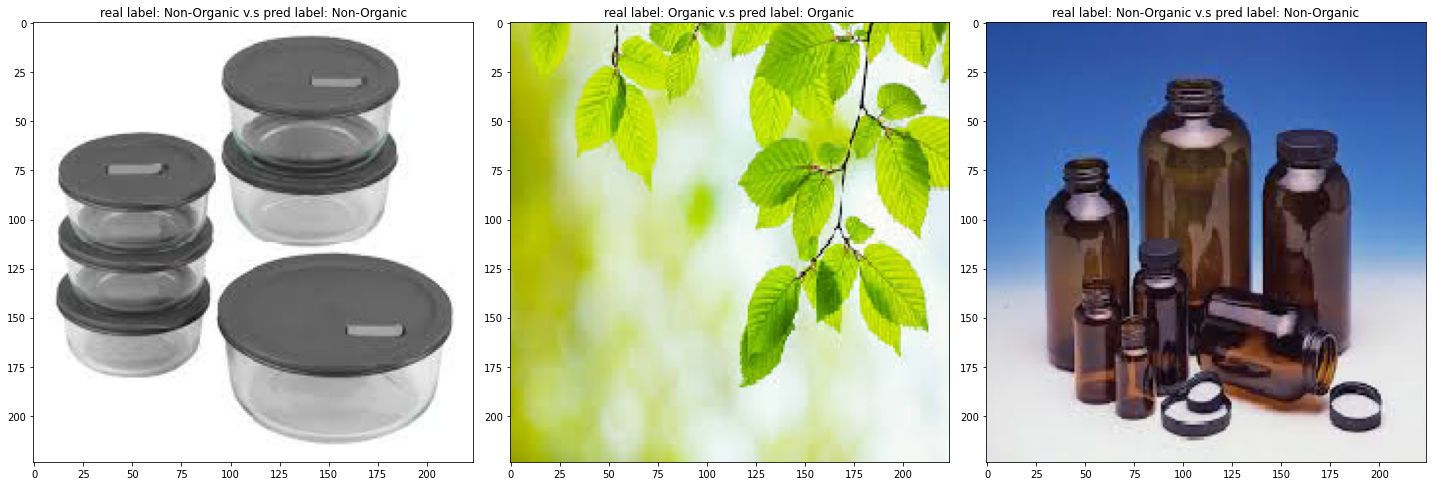

In [23]:

import numpy as np
images, labels = test_set.next()
preds = model.predict(images)
fig,axes=plt.subplots(ncols=3,figsize=(20,30))
dic={i:ax for i,ax in enumerate(axes.flat)}
for i in range(0,3):
    label = np.argmax(labels[i])
    pred = np.argmax(preds[i])
    image = images[i]
    dic[i].set_title('real label: ' + str(classes[label]) + " v.s " + 'pred label: ' + str(classes[pred]))
    dic[i].imshow(image)
plt.tight_layout()    
plt.show() 

In [24]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 16.2 MB 33.0 MB/s 
     |████████████████████████████████| 588.3 MB 6.6 kB/s 
     |████████████████████████████████| 40 kB 7.4 MB/s 
     |████████████████████████████████| 189 kB 69.3 MB/s 
     |████████████████████████████████| 237 kB 67.3 MB/s 
     |████████████████████████████████| 8.3 MB 61.5 MB/s 
     |████████████████████████████████| 154 kB 4.5 MB/s 
     |████████████████████████████████| 51 kB 3.5 MB/s 
     |████████████████████████████████| 439 kB 64.0 MB/s 
     |████████████████████████████████| 1.7 MB 64.6 MB/s 
     |████████████████████████████████| 6.0 MB 57.5 MB/s 
     |████████████████████████████████| 85 kB 5.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
    

In [25]:
# Specifies the model directory
model_dir = '/tmp/model'
try:
  os.mkdir(model_dir)
except OSError as e:
  print("\nUnable create directory. {}".format(e))

In [26]:
# Save model .h5
model_name = "model_v2"
model.save(model_dir+f"/{model_name}.h5")

In [27]:
# Download model .h5, for backup
files.download(os.path.join(model_dir, model_name + ".h5"))

print('model has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

model has been downloaded


In [29]:
# 1) Cek history training, cari path file weight terbaik
# Pada kasus ini yaitu: /tmp/best-weights/weights-improvement-40-0.99.hdf5
# HDF5 itu sama saja dengan H5 (versi penulisan format singkatnya)
files.download("/tmp/best-weights/weights-improvement-15-0.93.hdf5")

print('model has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

model has been downloaded


In [30]:
!tensorflowjs_converter \
    --input_format=keras \
    /tmp/model/model_v2.h5 \
    /tmp/tfjs_float_model

2022-11-27 18:51:39.978278: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.7/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-11-27 18:51:39.978511: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.7/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-11-27 18:51:39.978536: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [31]:
!zip -r /tmp/tfjs_float_model_v2.zip /tmp/tfjs_float_model

  adding: tmp/tfjs_float_model/ (stored 0%)
  adding: tmp/tfjs_float_model/group1-shard1of1.bin (deflated 8%)
  adding: tmp/tfjs_float_model/model.json (deflated 87%)


In [32]:
# Download model
files.download('/tmp/tfjs_float_model_v2.zip')

print('`tfjs_float_model_2.zip` has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`tfjs_float_model_2.zip` has been downloaded


In [33]:
!tensorflowjs_converter \
    --quantize_uint8 \
    --input_format=keras \
    --output_format=tfjs_layers_model \
    /tmp/model/model_v2.h5 \
    /tmp/tfjs_quant_model_present

2022-11-27 18:51:47.156021: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.7/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-11-27 18:51:47.156138: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.7/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-11-27 18:51:47.156158: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [34]:
!zip -r /tmp/tfjs_quant_model_v2.zip /tmp/tfjs_quant_model_present

  adding: tmp/tfjs_quant_model_present/ (stored 0%)
  adding: tmp/tfjs_quant_model_present/group1-shard1of1.bin (deflated 12%)
  adding: tmp/tfjs_quant_model_present/model.json (deflated 85%)


In [35]:
# Download model
files.download('/tmp/tfjs_quant_model_v2.zip')

print('`tfjs_quant_model_2.zip` has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`tfjs_quant_model_2.zip` has been downloaded
